In [1]:
import numpy as np
from scipy      import stats
from scipy      import integrate
from matplotlib import pyplot as plt
from astroML    import stats  as astroMLstats
from sklearn.neighbors          import KernelDensity
from astropy.visualization.hist import hist as fancyhist

For a BH of mass $M$ spin $\chi\in [0,1]$, the irreducible mass is 
\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\label{mirrdef}
\end{equation}
For convenience, let us define $f= M_{\rm irr}/M$

Suppose you have repeated measurments of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

**Tasks**:

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

In [2]:
sigma = 0.02
size  = 10**4
M     = np.random.normal(loc=1, scale=sigma, size=size)
chi   = np.random.uniform(0,1,size=size)
f     = np.sqrt((1+np.sqrt(1-chi**2))/2)
M_irr = M*f


2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

*Hint*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

Rule of thumb: **"Freedman-Diaconis rule"**: 

$$\Delta_b = \frac{2(q_{75}-q_{25})}{N^{1/3}} = \frac{2.7\sigma_G}{N^{1/3}}.$$

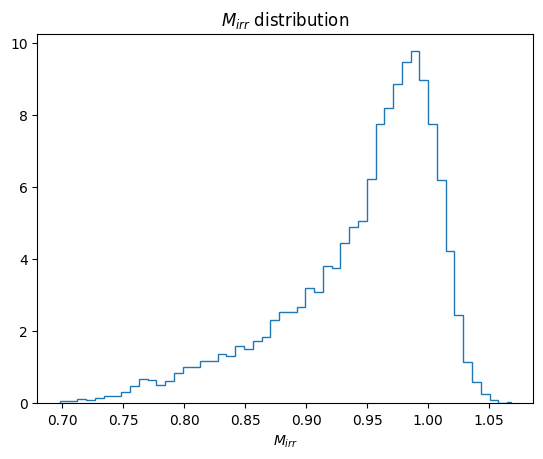

In [3]:
sigmaG    = astroMLstats.sigmaG(M_irr)
delta_bin = (2.7*sigmaG)/size**(1/3)
bins      = np.append(np.arange(start=M_irr.min(), stop=M_irr.max(), step=delta_bin) , M_irr.max())
plt.hist(M_irr, bins=bins, density=True, histtype='step')
plt.xlabel('$M_{irr}$')
plt.title('$M_{irr}$ distribution')
plt.show()

3. Using the same samples, plot the distribution of $M_{\rm irr}$ using a KDE.

In [4]:
x_axis = np.linspace(M_irr.min(), M_irr.max(), 10000)

def kde_sklearn(data, bandwidth, kernel):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_axis[:, np.newaxis]) # score_samples returns log(density)
    # so I need to return the exponential
    return np.exp(log_pdf)

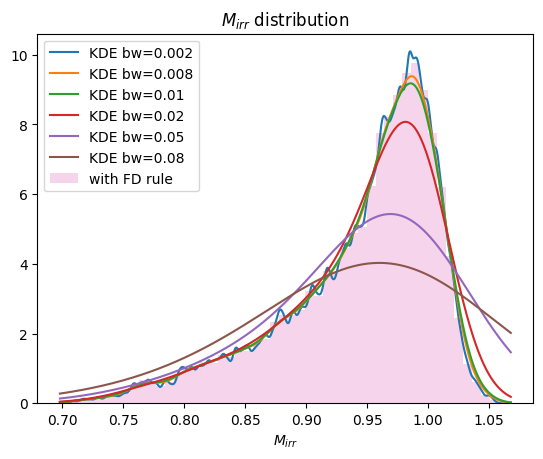

In [5]:
'''
the kernel doesn't change things much, the important part is the bandwidth
tophat = kde_sklearn(M_irr,bandwidth=0.02,kernel="tophat")
exp    = kde_sklearn(M_irr,bandwidth=0.02,kernel="exponential")
cos    = kde_sklearn(M_irr,bandwidth=0.02,kernel="cosine")
gauss  = kde_sklearn(M_irr,bandwidth=0.02,kernel="gaussian")
'''
bandwidth = [0.002,0.008,0.01,0.02,0.05,0.08]

gauss  = np.array([kde_sklearn(M_irr,bandwidth=num,kernel='gaussian') for num in bandwidth])

for idx, value in enumerate(bandwidth):
    plt.plot(x_axis, gauss[idx], label='KDE bw='+str(value))
    
plt.hist(M_irr, bins=bins, density=True, alpha=0.3, label='with FD rule')
plt.xlabel('$M_{irr}$')
plt.title('$M_{irr}$ distribution')
plt.legend()
plt.show()

4. Compute the KS distance between ${M_{\rm irr}}$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.
5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.
6. You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.

Let's see the distribution of $M$ (with a fixed $\sigma$) and $f$.

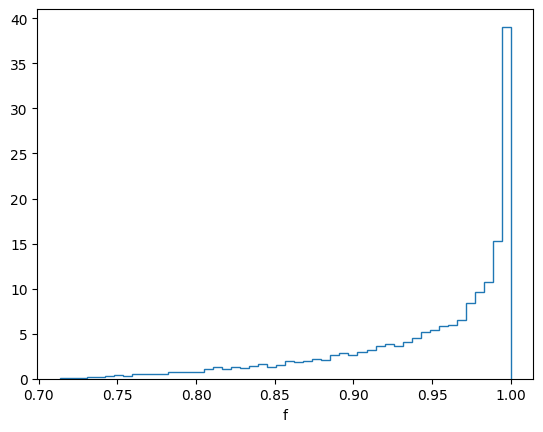

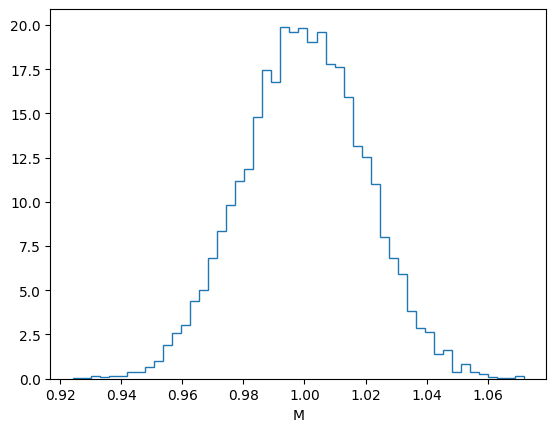

In [6]:
plt.hist(f,density=True,bins=50, histtype='step')
plt.xlabel('f')
plt.show()

plt.hist(M,density=True,bins=50, histtype='step')
plt.xlabel('M')
plt.show()

Let's see the distribution of $M_{irr}$ and $f$ in function of $\sigma$

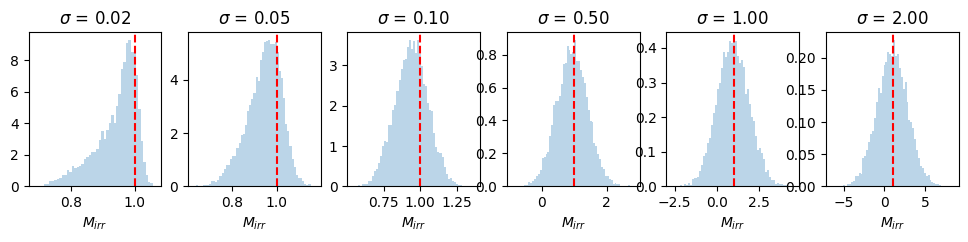

In [7]:
sigma   = [0.02,0.05,0.1,0.5,1,2]
size    = 10**4
fig,axs = plt.subplots(1,6,figsize=(12,2))

for s,ax in zip(sigma,axs):
    
    # Define the distribution
    M      = np.random.normal(loc=1, scale=s, size=size)
    chi    = np.random.uniform(0,1,size=size)
    f      = np.sqrt((1+np.sqrt(1-chi**2))/2)
    M_irr  = M*f
    
    # Shortcut for FD rule for bins
    fancyhist(M_irr,bins='freedman', ax=ax, alpha=0.3, density=True)
    ax.axvline(x=1, color='red', linestyle='--')
    ax.set_xlabel('$M_{irr}$')
    ax.set_title(r'$\sigma$ = %.2f'%s)

For small values of $\sigma<<\mu$, the distribution of $M_{irr}$ is distributed as $f$. <br>
For large values of $\sigma>>\mu$, the distribution of $M_{irr}$ is distributed more like $M$.

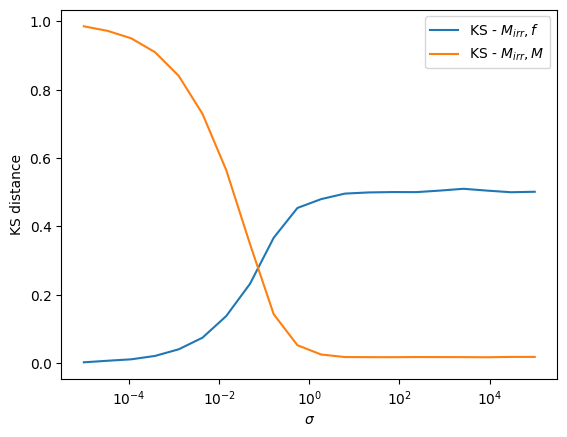

In [8]:
sigmas = np.logspace(-5,5,20)

ks_M = []
ks_f = []
for s in sigmas:
    
    M      = np.random.normal(loc=1, scale=s, size=size)
    chi    = np.random.uniform(0,1,size=size)
    f      = np.sqrt((1+np.sqrt(1-chi**2))/2)
    M_irr  = M*f
    
    ks_f.append(stats.ks_2samp(M_irr,f)[0])
    ks_M.append(stats.ks_2samp(M_irr,M)[0])
    
plt.plot(sigmas, ks_f, label="KS - $M_{irr}, f$")
plt.plot(sigmas, ks_M, label="KS - $M_{irr}, M$")
plt.xlabel("$\sigma$")
plt.ylabel('KS distance')
plt.legend()
plt.xscale('log')

The KS test is a non-parametric test used to compare the distributions of two samples to determine if they come from the same distribution. <br>
For small $\sigma$, $M_{irr}$ is distributed like $f$ (since their distance is approximately $0$).<br>
For large $\sigma$, $M_{irr}$ is distributed like $M$ (since their distance is approximately $0$).

NB In KS test, the null hypotesis is that the two samples are drawn from the same continuous distribution.

7. (At home...)  Compute the pdfs of $M_{\rm irr}$ from their mathematical definitions, plot them, and check they agree with your KDE.

*Hint 1*: First compute the pdf of $f$, that is just a change of variable. We saw how to do this in a previous lecture. The answer is:
\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}

(this is with $p(x) = dx/dy\;p(y)$)

*Hint 2*: Then compute the pdf of $M_{\rm irr}$, you want to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. The answer is only semi-analytic (unless you know how to solve that integral? If so please tell me!)
$$
p (M_{irr}) = \int_{-\infty}^{\infty}p_f(f)p_M\left(\frac{M_{irr}}{f}\right)\frac{1}{|f|}df
$$
which becomes
$$
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right] \frac{2 f^2-1}{f\sqrt{1 - f^2}}  \,\, {\rm d}f
$$

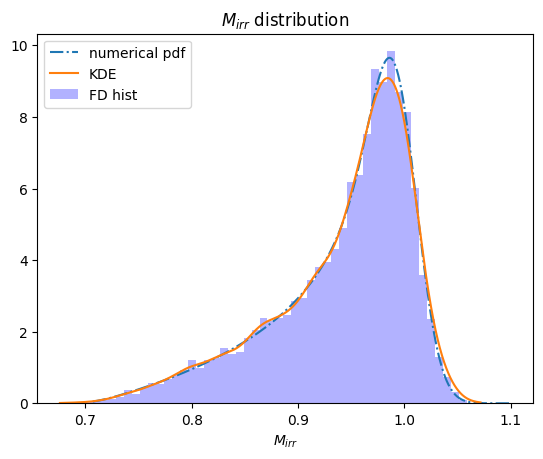

In [9]:
# Define the distribution
sigma  = 0.02
size   = 10**4
M      = np.random.normal(loc=1, scale=sigma, size=size)
chi    = np.random.uniform(0,1,size=size)
f      = np.sqrt((1+np.sqrt(1-chi**2))/2)
M_irr  = M*f
x_axis = np.linspace(M_irr.min(), M_irr.max(), 10000)

# I can integrate this integral numerically
def integral(f,x):
    return ((2/np.pi)**0.5 / sigma ) * np.exp(-(x/f -1)**2 /(2*sigma**2)) * (2*f**2-1)/(1 - f**2)**0.5 / f

x_grid    = np.linspace(min(1-5*sigma,1/np.sqrt(2)), 1+5*sigma, size)
pdf_M_irr = [integrate.quad(lambda f: integral(f,x), 1/np.sqrt(2), 1)[0] for x in x_grid]

plt.plot(x_grid, pdf_M_irr, '-.', label='numerical pdf')

# Plot KDE
KDE = kde_sklearn(M_irr,bandwidth=0.01,kernel='gaussian')
plt.plot(x_axis, KDE, label='KDE')

# and histogram
fancyhist(M_irr, bins='freedman', color='blue', alpha=0.3, density=True, label='FD hist')

plt.xlabel('$M_{irr}$')
plt.title('$M_{irr}$ distribution')
plt.legend()
plt.show()

My KDE approximates very well the analytical solution.